# Neural bigram model

The statistical bigram model is not very good at generating names. One way to improve it is to condition its probabilities on larger contexts beyond the immediately preceding character. However, this exponentially inflates the model’s parameter count. For instance, with a 51-character vocabulary, a statistical bigram model encompasses 2,601 probabilities, while a 3-gram model jumps to 132,651, and a 4-gram model has 6,765,201 probabilities.

In this notebook we will build an alternative bigram model grounded in neural networks. Instead of relying on direct probability estimates, we will train a softmax classifier that predicts the succeeding character based on the preceding one. While this model does not outperform the statistical bigram model, it scales better to longer contexts and larger vocabularies. Additionally, the neural architecture offers greater flexibility.

## Dataset

We re-use the names dataset and our code for building the character index.

In [1]:
# Load the list of names
with open('names.txt', encoding='utf-8') as fp:    
    names = [line.rstrip() for line in fp]

# Build the character index
char2idx = {'$': 0}
for name in names:
    for char in name:
        if char not in char2idx:
            char2idx[char] = len(char2idx)

This time, we store all bigrams in a list:

In [2]:
all_bigrams = []
for name in names:
    for bigram in zip('$' + name, name + '$'):
        all_bigrams.append(bigram)

The total number of bigrams in our data is 228,887:

In [3]:
len(all_bigrams)

228887

> **🤔 Problem 1: Total number of bigrams**
>
> Explain how to obtain the total number of bigrams in the data from the matrix we computed in the notebook on the statistical bigram model.

## One-hot representation

Neural networks require us to represent our data as vectors, matrices, and tensors. Here, we opt to represent preceding characters using **one-hot vectors**. The one-hot vector for a character $c_i$ has as many components as there are elements in our vocabulary, and is zero everywhere except in component&nbsp;$i$, where it takes the value one.

The next cell defines a function `vectorize` that takes a list of bigrams and returns a matrix $X$ and a vector $y$. The matrix $X$ has one row for each bigram, and that row is the one-hot vector for the first character of the corresponding bigram. The vector $y$ contains the integer indexes of the corresponding second characters.

In [4]:
import torch
import torch.nn.functional as F

def vectorize(bigrams):
    # Split the batch into inputs (previous characters) and outputs (next characters)
    xs, ys = zip(*bigrams)
    
    # Replace each character by its integer index
    xs = [char2idx[x] for x in xs]
    ys = [char2idx[y] for y in ys]

    # Convert inputs and outputs into tensors
    tensor_x = F.one_hot(torch.LongTensor(xs), len(char2idx)).float()
    tensor_y = torch.LongTensor(ys)

    return tensor_x, tensor_y

In [15]:
all_bigrams[:3]
len(all_bigrams)

228887

The code in the next cell computes the vectorised representation of the first three bigrams:

In [18]:
x, y = vectorize(all_bigrams)
x.shape, y.shape

(torch.Size([228887, 51]), torch.Size([228887]))

> **🤔 Problem 2: One-hot representation**
>
> Suppose we compute the vector representation for all bigrams in our dataset; this returns an $m$-by-$n$ matrix $X$ and an $m$-dimensional vector $y$. What are the values of&nbsp;$m$ and&nbsp;$n$?

## Training the model

We are now ready to set up a softmax regression model and train it using cross-entropy loss.

To refresh, a softmax regression model consists of a linear layer followed by the softmax function. In PyTorch, we can employ the [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) class for linear layers and use the [`nn.functional.cross_entropy()`](https://pytorch.org/docs/stable/nn.functional.html#cross-entropy) function to compute the cross-entropy loss. It is crucial to note that this function requires pre-softmax logits as input, not probabilities. As a consequence, we do not actually need the softmax function for training the model.

We train our model using gradient descent using the [`utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) abstraction. Iterating over a data loader yields small batches of the underlying dataset – in our case, batches of bigrams. We configure the data loader to send each such batch through the one-hot vectoriser we defined above using the `collate_fn` keyword.

In [19]:
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader

# Hyperparameters
num_epochs = 8
batch_size = 32
lr = 1e-1

# Initialise the model
# one score for each of our characters in output
model = nn.Linear(len(char2idx), len(char2idx))

# Initialise the optimiser (stochastic gradient descent)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Initialise the data loader
data_loader = DataLoader(all_bigrams, batch_size=batch_size, collate_fn=vectorize, shuffle=True)

# We train for the specified number of epochs
for _ in range(num_epochs):

    # In each epoch, we loop over the batches provided by the data loader
    for batch_x, batch_y in data_loader:

        # Reset the accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model.forward(batch_x)

        # Compute the loss
        loss = F.cross_entropy(output, batch_y)

        # Backward pass: propagate the loss and compute the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()

Here is an embellished version of the training loop that plots the per-epoch losses.

100%|██████████| 8/8 [00:46<00:00,  5.76s/it]


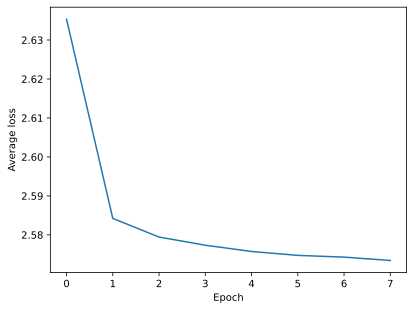

In [20]:
# Embellished training loop with plotting

import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader

import tqdm
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

num_epochs = 8
batch_size = 8
lr = 1e-1

model = nn.Linear(len(char2idx), len(char2idx))
optimizer = optim.SGD(model.parameters(), lr=lr)
data_loader = DataLoader(all_bigrams, batch_size=batch_size, collate_fn=vectorize, shuffle=True)
losses = []
with tqdm.tqdm(total=num_epochs) as pbar:
    for _ in range(num_epochs):
        running_loss = 0
        for batch_x, batch_y in data_loader:
            optimizer.zero_grad()
            output = model.forward(batch_x)
            loss = F.cross_entropy(output, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(batch_x)
        losses.append(running_loss / len(all_bigrams))
        pbar.update()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()

By looking at the loss curve, we can confirm that the network is actually learning to predict the next character from the previous one.

## Evaluation

The code in the next cell computes the perplexity of our neural model. The code is considerably simpler than in the notebook on the statistical bigram model because the average negative log likelihood we need to compute as a first step is exactly the cross-entropy loss.

In [21]:
# Do the following without gradient calculation
with torch.no_grad():

    # Get the vectorised version of all bigrams
    test_x, test_y = vectorize(all_bigrams)

    # Compute the cross-entropy loss (= average negative log likelihood)
    loss = F.cross_entropy(model.forward(test_x), test_y)

    # Print as perplexity
    print(f'{torch.exp(loss):.1f}')

13.1


As we can see, the perplexity of the neural bigram model is only slightly higher than that of its statistical counterpart.

> **🤔 Problem 3: Improving the perplexity**
>
> Try to improve the perplexity of the model by changing the training hyperparameters: number of epochs, batch size, learning rate. Building on your previous machine learning knowledge, do you have other ideas for how you could improve perplexity?

## Sampling from the model

Finally, we present code that generates text by repeatedly sampling from the neural model. The general structure of this code is very similar to that of the corresponding code for the statistical bigram model; the main differences are in the input to and output from the model. Note that in this code we actually use the softmax function (implemented in [`nn.functional.softmax()`](https://pytorch.org/docs/stable/nn.functional.html#cross-entropy)) to convert the logits into proper probabilities.

In [22]:
# Construct the index-to-character mapping
idx2char = {i: c for c, i in char2idx.items()}

# Do the following without gradient calculation
with torch.no_grad():

    # Generate 5 samples
    for _ in range(5):

        # We begin with the start-of-sequence marker
        generated = '$'

        while True:
            # Look up the integer index of the previous character
            previous_char = [char2idx[generated[-1]]]

            # Construct the corresponding one-hot vector
            x = F.one_hot(torch.LongTensor(previous_char), len(char2idx)).float()

            # Get the logits (negative log probabilities)
            logits = model.forward(x)

            # Turn the logits into a probability distribution
            p = F.softmax(logits, dim=-1)

            # Sample from the distribution
            y = torch.multinomial(p, num_samples=1).item()

            # Get the corresponding character
            next_char = idx2char[y]

            # Break if the model generates the end-of-sequence marker
            if next_char == '$':
                break

            # Add the next character to the output
            generated = generated + next_char

        # Print the generated output (without the start-of-sequence marker)
        print(generated[1:])

h
mist
ishae
n
rwaranare


> **🤔 Problem 4: Sampling with temperature**
>
> We can refine sampling by introducing a hyperparameter called **temperature**. This setting controls the randomness of the model output and prevents the model from replicating patterns in the training data too closely. Practically, we divide the logits by a value $T > 0$ before sending them through the softmax function. What is the effect of that? How do the generated names change when you introduce temperature into the sampling procedure?

That’s all folks!